In [1]:
import numpy as np
import tensorflow as tf
import os

from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow.keras.models import load_model # type: ignore
from tensorflow import keras
from tensorflow.keras import backend as K # type: ignore


from glob import glob
from PIL import Image

from utils import *


In [2]:
size = 256
INPUT_SHAPE = (size, size, 3)
OUTPUT_SHAPE = (size, size, 1)
IMAGE_COUNT = 5

BATCH_SIZE = 64



In [3]:
image_paths = sorted(glob(os.path.join("dane/obrazy", '*.jpg')))
mask_paths = sorted(glob(os.path.join("dane/naczynia", '*.tif')))

print(len(image_paths))
print(len(mask_paths))

def load_images(image_paths, mask_paths):
    images = []
    masks = []
    
    for image_path, mask_path in zip(image_paths, mask_paths):
        sub_images = split_image(image_path, INPUT_SHAPE[:2])
        sub_masks = split_image(mask_path, OUTPUT_SHAPE[:2])

        for sub_image, sub_mask in zip(sub_images, sub_masks):
            images.append(tf.convert_to_tensor(sub_image / 255.0, dtype=tf.float32))
            
            gray_mask = Image.fromarray(sub_mask).convert('L')
            gray_mask = np.array(gray_mask)
            
            gray_mask = (gray_mask > 127).astype(np.int32)  
            gray_mask = np.expand_dims(gray_mask, axis=-1) # dodano w wersji drugiej

            masks.append(tf.convert_to_tensor(gray_mask, dtype=tf.float32)) #zmieniono na float32 w wersji drugiej (z int32)

    images = tf.stack(images)
    masks = tf.stack(masks)
    return images, masks

train_images, train_masks = load_images(image_paths[:IMAGE_COUNT], mask_paths[:IMAGE_COUNT])
dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks))
dataset = dataset.shuffle(1000).batch(BATCH_SIZE)
augmenter = Augment()
dataset = dataset.map(augmenter.call, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

for images, masks in dataset.take(1):
    print(images[0].shape, masks[0].shape)
    max_value_image = tf.reduce_max(images[0])
    max_value_mask = tf.reduce_max(masks[0])

    print("Max value in image:", max_value_image.numpy())
    print("Max value in mask:", max_value_mask.numpy())

TRAIN_LENGTH = len(train_images)
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE



45
45
(256, 256, 3) (256, 256, 1)
Max value in image: 0.84313726
Max value in mask: 1.0


Rozmiar zbioru treningowego: 1040
Przykładowy obraz: dane/obrazy\01_dr.JPG


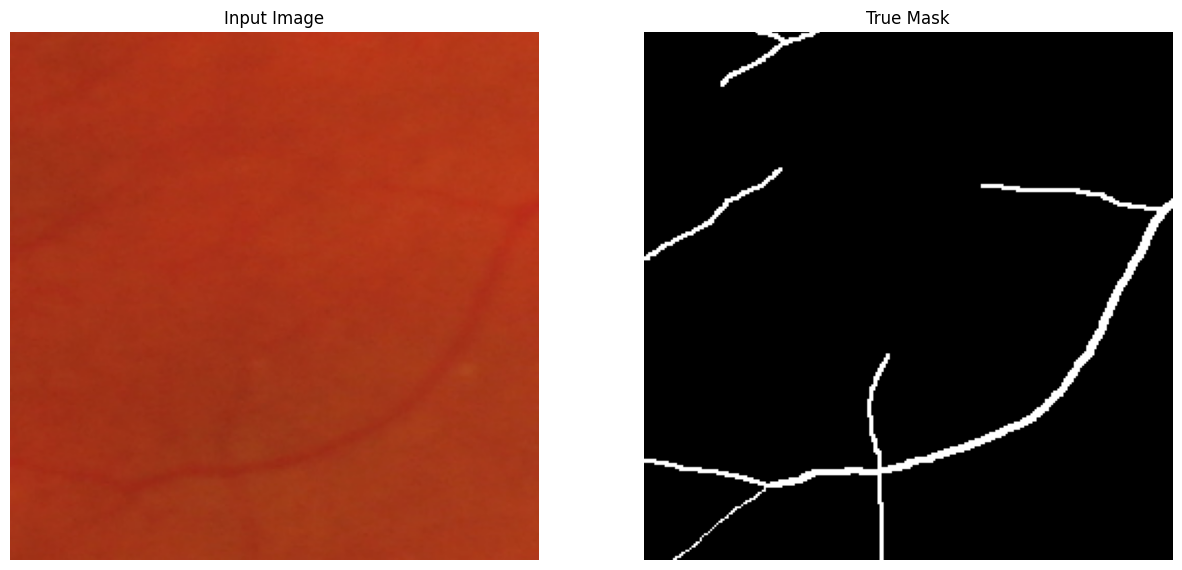

In [4]:
print("Rozmiar zbioru treningowego:", len(train_images))
print("Przykładowy obraz:", image_paths[0])

for images, masks in dataset.take(1):
    display([images[0], masks[0]])


In [5]:
base_model = tf.keras.applications.MobileNetV2(input_shape=INPUT_SHAPE, include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(INPUT_SHAPE)

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  # last = tf.keras.layers.Conv2DTranspose(
  #     filters=output_channels, kernel_size=3, strides=2,
  #     padding='same')  #64x64 -> 128x128
  last = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=2, padding='same', activation='sigmoid')  # dodane w wersji drugiej
  x = last(x)

  
  return tf.keras.Model(inputs=inputs, outputs=x)

C:\Users\szulc\AppData\Local\Temp\ipykernel_19436\2252463713.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=INPUT_SHAPE, include_top=False)


In [6]:


#model = unet_model(output_channels=2)
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     metrics=['accuracy']
# )


def dice_coef(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)  # Rzutowanie do float32
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)



model = unet_model(output_channels=1)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[ dice_coef]
)

In [7]:
model = load_model('modele/M3.keras', custom_objects={'dice_coef': dice_coef})

In [ ]:
EPOCHS = 15

model.fit(
    dataset,
    epochs= EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    verbose=1
)

    


In [ ]:
model.save('modele/M3.keras')

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 551ms/step


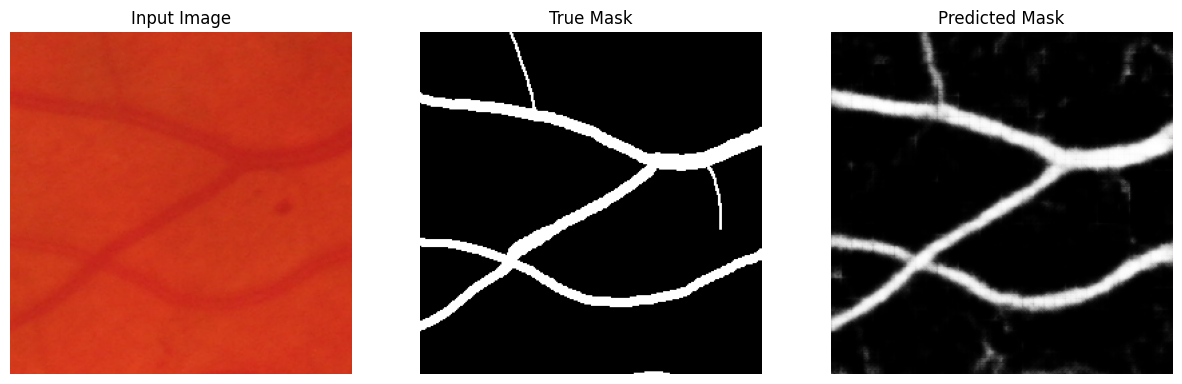

Maksymalna wartość wygenerowanego obrazu: 0.999992311000824
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


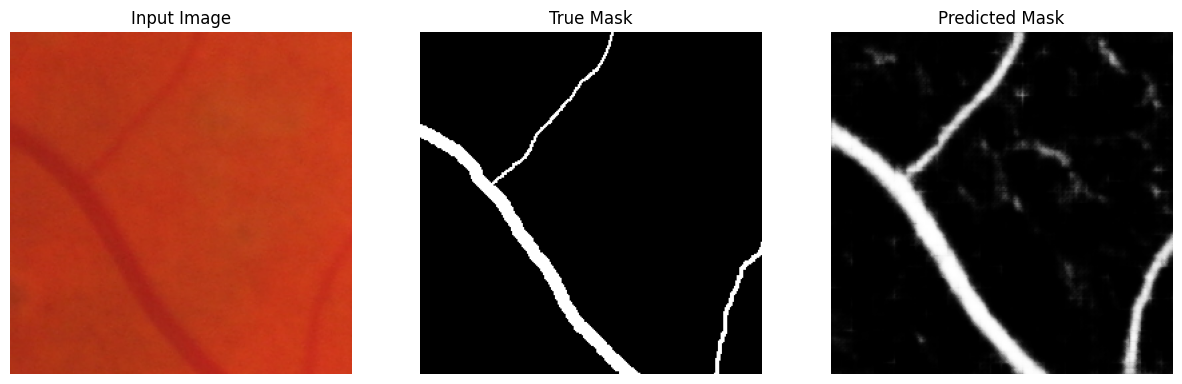

Maksymalna wartość wygenerowanego obrazu: 0.9999961853027344
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


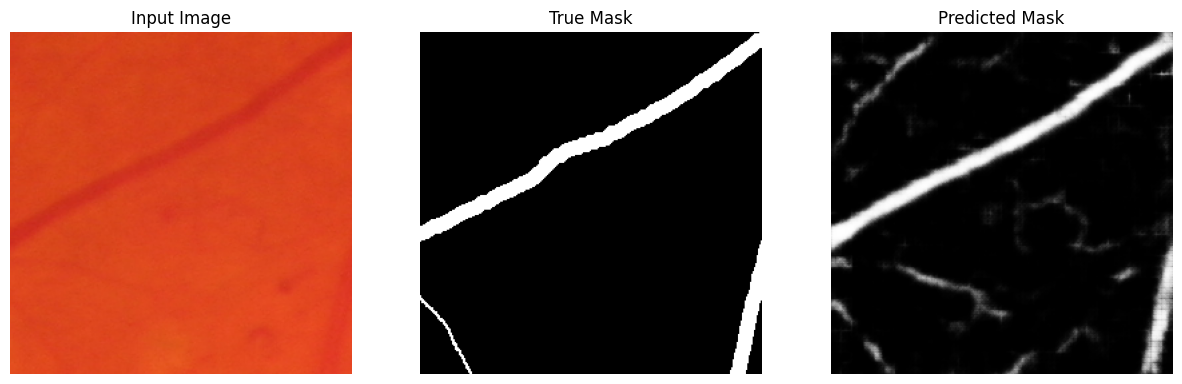

Maksymalna wartość wygenerowanego obrazu: 0.9999956488609314


In [8]:

def show_predictions(dataset, num=1):
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], pred_mask[0]])
      max_value_mask = tf.reduce_max(pred_mask)
      print(f"Maksymalna wartość wygenerowanego obrazu: {max_value_mask}")

show_predictions(dataset, 3)


Wykonywanie predykcji na obrazie: dane/obrazy/14_h.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/

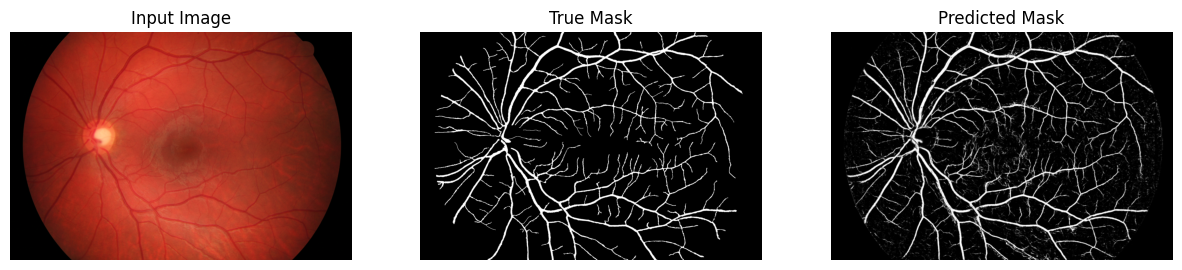

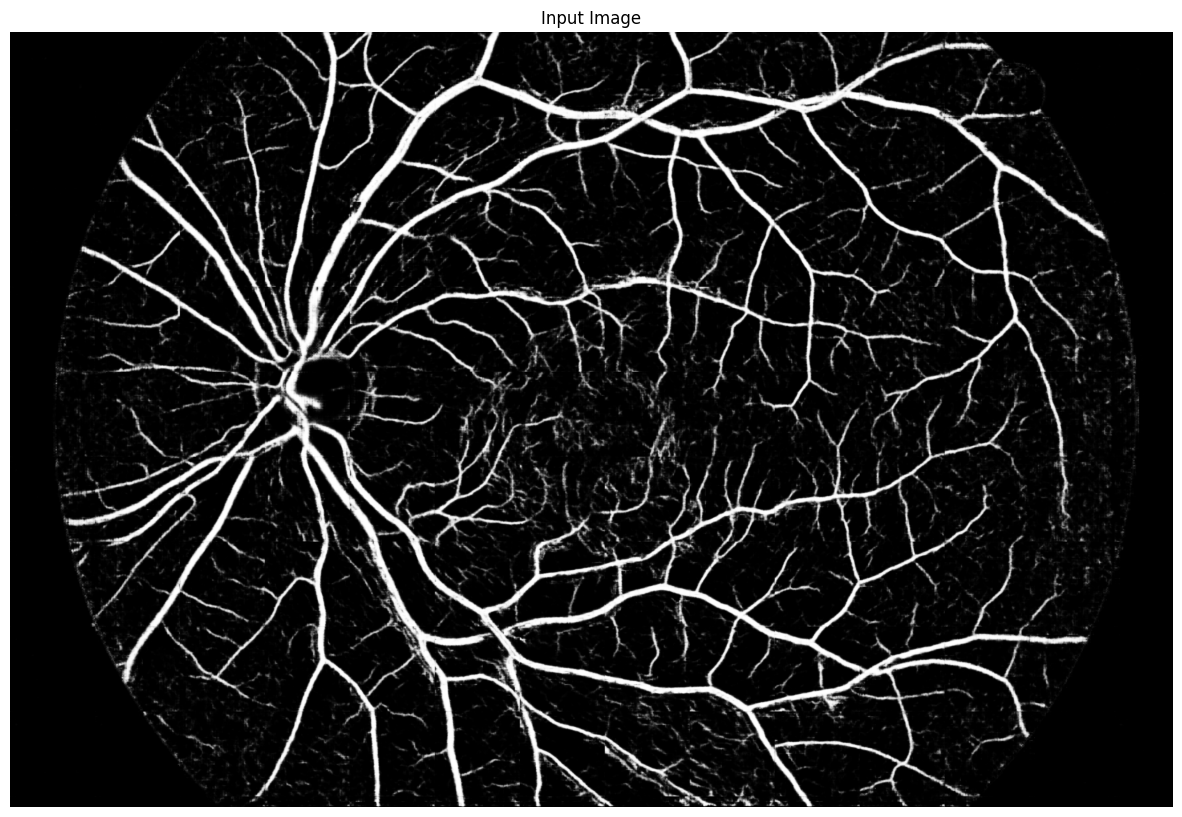

In [17]:
def predict_image(model, image_path, tile_size=(256, 256), fill_color=(0, 0, 0)):

    print("Wykonywanie predykcji na obrazie:", image_path)
    
    with Image.open(image_path) as img:
        img = img.convert("RGB")
        img_width, img_height = img.size
        tile_width, tile_height = tile_size

        # Oblicz wymiary po dopełnieniu
        padded_width = ((img_width + tile_width - 1) // tile_width) * tile_width
        padded_height = ((img_height + tile_height - 1) // tile_height) * tile_height

        # Stwórz nowy obraz z dopełnieniem
        padded_img = Image.new("RGB", (padded_width, padded_height), fill_color)
        padded_img.paste(img, (0, 0))

        # Przygotowanie pustej maski na wynik
        full_mask = np.zeros((padded_height, padded_width), dtype=np.float32)

        # Podziel obraz na kafelki i sklejaj predykcje
        for top in range(0, padded_height, tile_height):
            for left in range(0, padded_width, tile_width):
                box = (left, top, left + tile_width, top + tile_height)
                tile = padded_img.crop(box)
                
                # Konwersja do tablicy numpy, dodanie wymiaru batch
                img = np.array(tile)
                img = np.expand_dims(img, axis=0)  # Kształt (1, 256, 256, 3)
                img = tf.convert_to_tensor(img / 255.0, dtype=tf.float32)
                
                pred_mask = model.predict(img)
                #print(pred_mask.shape)
                pred_mask = np.squeeze(pred_mask, axis=0) 
                pred_mask = pred_mask.reshape(OUTPUT_SHAPE[:2])
                threshold = 0.14  
                #pred_mask = (pred_mask > threshold).astype(np.uint8)
                #print(pred_mask.shape)

                full_mask[top:top + tile_height, left:left + tile_width] = pred_mask

        final_mask = full_mask[:img_height, :img_width]
        return final_mask

file = 'dane/obrazy/14_h.jpg'
file_mask = 'dane/naczynia/14_h.tif' 
original_image = read_image(file)
original_mask = read_image(file_mask)
image = predict_image(model, file, tile_size=INPUT_SHAPE[:2])

print(original_image.shape)
print(original_mask.shape)
print(image.shape)
display([original_image, original_mask, image])

display([image])

#grid_display([image])

Maksymalna wartość w predykcji: 255
Maksymalna wartość w masce eksperckiej: 255


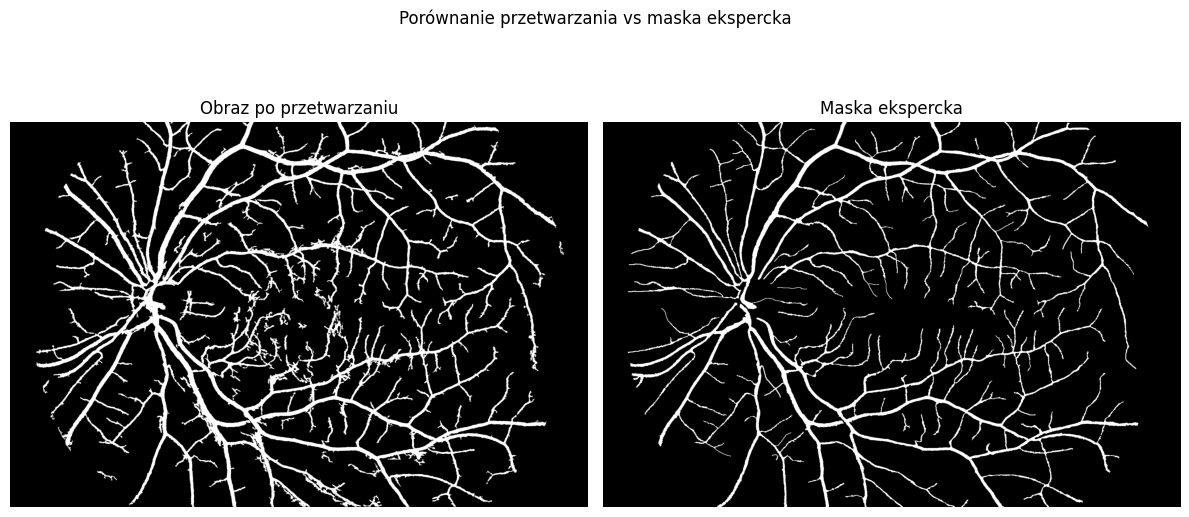

| Method     |   Accuracy |   Sensitivity |   Specificity |   Balanced Accuracy |   G-Mean |
|:-----------|-----------:|--------------:|--------------:|--------------------:|---------:|
| Normalized |     0.9402 |        0.9365 |        0.9406 |              0.9385 |   0.9385 |


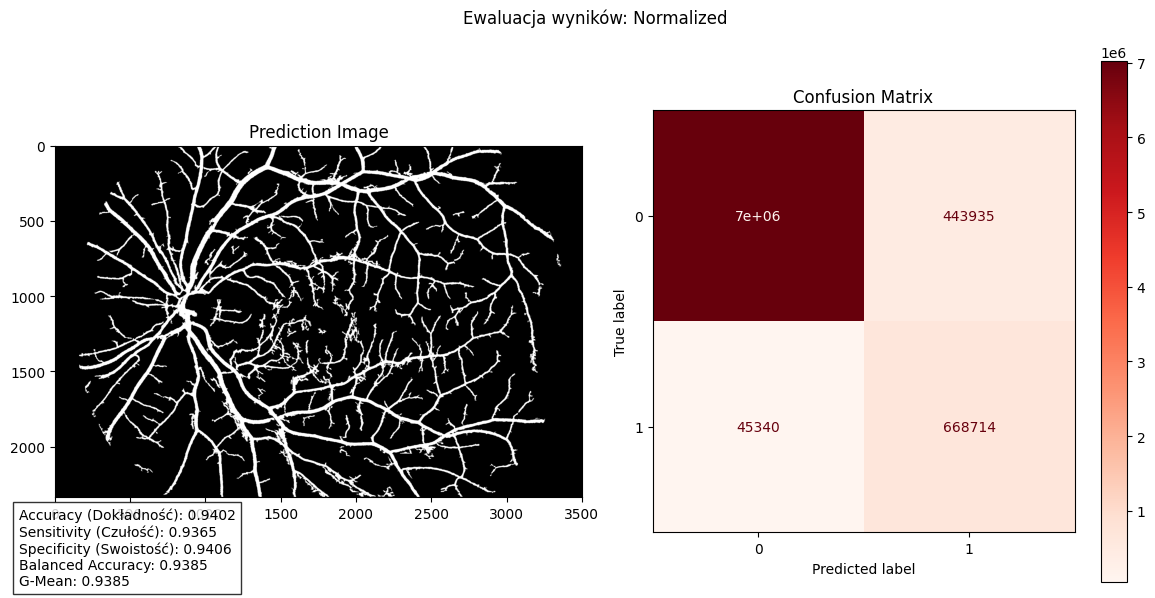

In [22]:
import cv2 


img = (image * 255).astype(np.uint8)


def remove_small_objects(image, min_size=100):
    # Zakładamy: image = uint8 w skali 0–255
    _, binary = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY)  # lub użyj adaptive threshold
    
    # Connected components
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary, connectivity=8)
    
    # Tworzymy maskę tylko dla dużych obiektów
    output = np.zeros_like(image)
    for i in range(1, num_labels):  # pomijamy tło (label 0)
        if stats[i, cv2.CC_STAT_AREA] >= min_size:
            output[labels == i] = 255
    
    return output

# img_uint8 to twój obraz (uint8)
cleaned = remove_small_objects(img, min_size=800)


#display([cleaned])
img_true = cv2.imread(file_mask, cv2.IMREAD_GRAYSCALE)
evaluate_segmentation(cleaned, img_true)